# Whitepaper HashJing

In [376]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import sys
sys.path.append("..")

import importlib
import hash_utils.base_hash as base_hash
importlib.reload(base_hash)
print()

## Introduction

**HashJing** is a philosophical and aesthetic experiment at the intersection of generative art, cryptography, and Eastern East Asian symbolism. The name combines “hash” (a unique digital fingerprint) and the character **經** *jīng* — “canon” or “classical text.” In other words, it is a “Canon of the Hash”: a deterministic form where entropy becomes observable order.

Each 256-bit hash is transformed into a **mandala of 64 radial sectors, and 4 concentric layers**: one hex symbol → one sector, one bit → one layer. This transformation of number into image raises questions: can randomness become meaningful? What if we view digital structures as modern ideograms? Where is the boundary between entropy and canon? References to the 64 hexagrams of the *the I Ching* and the Daoist diagram of Wuji → Taiji connect this inquiry to an ancient tradition of contemplating change.

All functions used throughout this notebook are collected in a single module:
[**base\_hash.py**](https://github.com/DataSattva/hashjing/blob/main/hash_utils/base_hash.py)
This file serves as the central utility library for hash generation, bit manipulation, mandala structure parsing, and feature extraction.

## 1. Hash and Randomness

### What is a Hash?

A **hash function** is a mathematical transformation that takes an input (a string, file, or data block) and produces a fixed-length fingerprint — typically 256 or 160 bits.

Key characteristics:

* It is **one-way**: it's easy to compute a hash from an input, but practically impossible to recover the input from the hash;
* It is **collision-resistant**: it’s extremely unlikely that two different inputs will produce the same hash;
* It is **sensitive to input changes**: even a single altered character will completely change the output.

Hashes are widely used in cryptography, blockchain systems (e.g. Bitcoin, Ethereum), digital signatures, and data verification.

In HashJing, hashes are not just cryptographic primitives — they serve as raw material for visual pattern generation. By treating each bit as a building block of form, the system transforms invisible entropy into visible structure.

You can generate a 256-bit or 160-bit hash from any string (e.g. `“HashJing“`) using the functions provided in the utility module [base_hash.py](https://github.com/DataSattva/hashjing/blob/main/hash_utils/base_hash.py)

In [401]:
print(f"➜ SHA-256 (default): {base_hash.hash_to_hex('HashJing')}")
print(f"➜ SHA-256, truncated: {base_hash.hash_to_hex('HashJing', bits=160)}")
print(f"➜ Ethereum-style Keccak-256: {base_hash.hash_to_hex('HashJing', algo='keccak')}")
print(f"➜ Ethereum-style Keccak-160: {base_hash.hash_to_hex('HashJing', bits=160, algo='keccak')}")

➜ SHA-256 (default): 0x2b054d225d025fc24c58030bda276b16089ae21cc8aff93d2751472a98eab06c
➜ SHA-256, truncated: 0xda276b16089ae21cc8aff93d2751472a98eab06c
➜ Ethereum-style Keccak-256: 0xe302944827d82597ebdf074bb01066f8d99378130f3f6fa065a25e5fea433afd
➜ Ethereum-style Keccak-160: 0xb01066f8d99378130f3f6fa065a25e5fea433afd


Each of these produces a valid input for visual encoding into a mandala.

### On Randomness and Security

The function `generate_random_hash()` **relies on cryptographically secure pseudorandom number generators (CSPRNGs)**, so every output is _statistically indistinguishable from true randomness_.

* With `algo="sha256"`, entropy is **sourced with** `secrets.token_hex()`, which draws from the operating system’s CSPRNG (e.g., `/dev/urandom` on Unix-like systems).
* With `algo="keccak"`, entropy bytes are **fed into** the Keccak-256 sponge function, yielding a deterministic digest from a high-entropy seed. **Keccak-256 is the final version of the algorithm that won the SHA-3 competition.**

Although both paths are deterministic, their results remain **computationally unpredictable unless the internal state of the generator is known**, making them suitable for cryptographic as well as generative-art applications.


### Hash in HashJing

In the generative system **HashJing**, everything begins with a **cryptographic hash** — typically a **256-bit string** consisting of 64 hexadecimal characters prefixed with `0x`. Each hash serves as a unique seed for visual generation.

Cryptographic hashes possess two essential properties:

* **Determinism** — the same input always produces the same output;
* **Apparent randomness** — even a tiny change in input leads to an unpredictable, drastically different result.

This combination makes the hash an ideal bridge between number and image: it guarantees repeatability while preserving complexity and surprise.

In practice, HashJing supports both:

* **256-bit hashes**, such as those generated via SHA-256 (the default);
* **160-bit hashes**, which yield shorter, 40-sector mandalas — analogous in length to Ethereum addresses;
* and optionally, **Keccak-256**, the hashing standard used in Ethereum (available for both 160 and 256 bits).

These options allow for creative control and compatibility with Web3-native data.

### Hash generation from text

In **HashJing**, you can derive a cryptographic hash from any input string—whether it’s a meaningful phrase, a wallet address, or an emblematic word—and immediately turn that hash into a visual pattern. For example:

In [432]:
hash_hex = base_hash.hash_to_hex('HashJing')
print(hash_hex)

0x2b054d225d025fc24c58030bda276b16089ae21cc8aff93d2751472a98eab06c


This command produces a **256-bit SHA-256 hash** from the input `“HashJing“`. The result is a hexadecimal string that can be directly used to generate a mandala:

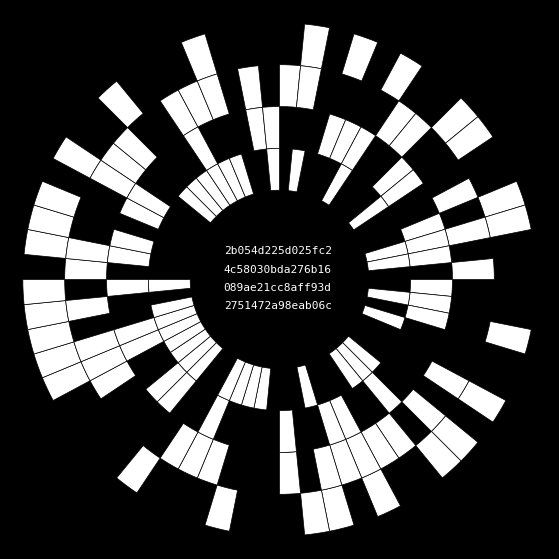

Figure 1. Mandala of the SHA-256 hash for “HashJing“: 0x2b054d225d025fc24c58030bda276b16089ae21cc8aff93d2751472a98eab06c



In [474]:
base_hash.draw_mandala(hash_hex)
print(f'Figure 1. Mandala of the SHA-256 hash for “HashJing“: {hash_hex}\n')

> **Note:** The geometric rules behind this circular mandala—how bits map to rings and sectors—are outlined only briefly here. A complete, step-by-step explanation is presented in the following sections.

You can also specify the bit length or algorithm:

In [400]:
print(f"➜ 160-bit SHA-256-derived hash: {base_hash.hash_to_hex('HashJing', bits=160)}")
print(f"➜ Ethereum-style Keccak-256 hash: {base_hash.hash_to_hex('HashJing', algo='keccak')}")

➜ 160-bit SHA-256-derived hash: 0xda276b16089ae21cc8aff93d2751472a98eab06c
➜ Ethereum-style Keccak-256 hash: 0xe302944827d82597ebdf074bb01066f8d99378130f3f6fa065a25e5fea433afd


This allows full flexibility in generating deterministic, symbolically meaningful mandalas from text.

### Why SHA-256?

We use **SHA-256** (Secure Hash Algorithm 256-bit) because it is:

* **Widely adopted** and battle-tested across cryptographic and blockchain applications.
* Produces a **fixed 256-bit output** (64 hex characters), which maps naturally to our 4×64 bit mandala grid.
* Used by Bitcoin, Ethereum, and many decentralized protocols, which gives symbolic resonance to our structures.

While other algorithms exist (SHA-1, SHA-3, BLAKE2, RIPEMD-160), SHA-256 remains the **de facto standard** for secure and verifiable digital entropy. It offers a perfect balance between structure, randomness, and computational predictability — all essential for generative encoding of symbolic geometry.

The resulting 64 hex characters can be easily interpreted as 256 bits → **64 radial sectors × 4 concentric layers** in the HashJing visualization algorithm (1 hex character → 1 sector, 1 bit → 1 layer). Thus every hex character occupies a unique radial slice, and its four bits are stacked as four concentric rings inside that slice.
This transformation from number to image will be described in detail in the next sections.

### Where to Get Hashes in the Blockchain

| Source                              | Usage in NFT minting                                        | Size                |
| ----------------------------------- | ----------------------------------------------------------- | ------------------- |
| `tokenData.hash` (Art Blocks)       | Automatically assigned to token during mint                 | 256 bits (32 bytes) |
| `blockhash(n)`                      | Block-level randomness, often used as a `seed`              | 256 bits (32 bytes) |
| `keccak256(tokenId ∥ secret)`       | User-defined method for unpredictable but reproducible hash | 256 bits (32 bytes) |
| `sha256`, `blake2b`, Poseidon, Rescue, etc. | Off-chain generation for zk-friendly proofs (StarkNet, zk-Rollups)        | r + c bits, typically 256              |

#### Deterministic Randomness as a Mirror of Form

Hashes turn invisible entropy into visible order. The mandala reveals hidden symmetries, rhythms and repetitions that lie dormant in 256 raw bits — the *yīn*-*yáng* of digital entropy at the heart of HashJing.

## 2. Binary Representation of Numbers and the Schemes of the “Book of Changes”

The *the I Ching* (易經, *Yìjīng*) — the “Book of Changes” — is arguably the first known example of **binary notation** in human history.
Its “alphabet” is the **hexagram**: a vertical stack of 6 lines, where

| Line   | Symbol | Bit | Semantics                     |
| ------ | ------ | --- | ----------------------------- |
| broken | — —    | 0   | 陰 *yīn* — darkness, passivity |
| solid  | ——    | 1   | 陽 *yáng* — light, activity    |

Each hexagram is thus encoded as a number **from 0 to 63** (2⁶=64 combinations).  The **least significant bit** is the top line, the **most significant** is the bottom.

| Line index | 0 (000000) | 1 (000001) | 2 (000010) |  …  | 62 (111110) | 63 (111111) |
| :------------: | :--------: | :--------: | :--------: | :-: | :---------: | :---------: |
|        ⑥       |     — —    |     ——    |     — —    |     |     — —     |     ——     |
|        ⑤       |     — —    |     — —    |     ——    |     |     ——     |     ——     |
|        ④       |     — —    |     — —    |     — —    |     |     ——     |     ——     |
|        ③       |     — —    |     — —    |     — —    |     |     ——     |     ——     |
|        ②       |     — —    |     — —    |     — —    |     |     ——     |     ——     |
|        ①       |     — —    |     — —    |     — —    |     |     ——     |     ——     |

**Table of vertical bit layouts for hexagrams in binary order.**
Rows ⑥ → ① represent lines from top (least significant bit) to bottom (most significant); columns show the first three and last two hexagrams of the 0–63 range. `——` denotes a *yáng* line (1), `— —` a *yīn* line (0); `…` indicates omitted intermediate columns.

![Circular arrangement of 64 hexagrams](pic/yi_circle.jpg)  
**Figure 2.** Circular arrangement of the 64 hexagrams (binary order)


**Circular diagram of the 64 hexagrams in ascending binary order.**  
The starting point is **Kūn** `000000` at the top. Moving clockwise, we add **1** to the six-bit number with each step: `000001`, `000010`, … until the cycle closes at **Qián** `111111`. Black = *yīn* 0, white = *yáng* 1.  
This **ascending order** matches the way HashJing fills its 64 sectors.

### From Hexagrams to HashJing

HashJing takes the same idea of binary motifs and applies it to a modern **256-bit hash** (SHA-256 / Keccak-256):

```
0x87a797a48cba94ee585ee2c0d7d6f4cce4dd12f77192a4d0bc562938d6fb62b1
```

* 64 hex characters → **64 “sectors”** of the mandala
* Each hex = 4 bits → **4 concentric layers** (from center to periphery)

Thus emerges a natural bridge between cryptographic randomness and the binary cosmology of the *the I Ching*: instead of six stacked lines we now read four nested rings, yet the mapping **“least significant bit → innermost layer”** mirrors the classical idea that genesis starts at the base and unfolds outward.

## 3. The Principle of Diagram Construction

HashJing interprets a 256-bit hash as **64 hexadecimal characters**.
Each hex character → **4 bits** → one radial sector with 4 concentric cells.

### ▸ Binary Decomposition

*Each hex character is explicitly mapped to its 4 bits (from least to most significant).*


In [479]:
my_hash = base_hash.generate_random_hash()
print(f'my_hash = {my_hash}\n')
base_hash.explain_hex_to_bin(my_hash)

my_hash = 0xb519d20b79f771fd49241adb444c75ba8439b27fe65f82dc8af9157d73c9f718

00: B -> 1011
01: 5 -> 0101
02: 1 -> 0001
03: 9 -> 1001
04: D -> 1101
05: 2 -> 0010
06: 0 -> 0000
07: B -> 1011
08: 7 -> 0111
09: 9 -> 1001
10: F -> 1111
11: 7 -> 0111
12: 7 -> 0111
13: 1 -> 0001
14: F -> 1111
15: D -> 1101
16: 4 -> 0100
17: 9 -> 1001
18: 2 -> 0010
19: 4 -> 0100
20: 1 -> 0001
21: A -> 1010
22: D -> 1101
23: B -> 1011
24: 4 -> 0100
25: 4 -> 0100
26: 4 -> 0100
27: C -> 1100
28: 7 -> 0111
29: 5 -> 0101
30: B -> 1011
31: A -> 1010
32: 8 -> 1000
33: 4 -> 0100
34: 3 -> 0011
35: 9 -> 1001
36: B -> 1011
37: 2 -> 0010
38: 7 -> 0111
39: F -> 1111
40: E -> 1110
41: 6 -> 0110
42: 5 -> 0101
43: F -> 1111
44: 8 -> 1000
45: 2 -> 0010
46: D -> 1101
47: C -> 1100
48: 8 -> 1000
49: A -> 1010
50: F -> 1111
51: 9 -> 1001
52: 1 -> 0001
53: 5 -> 0101
54: 7 -> 0111
55: D -> 1101
56: 7 -> 0111
57: 3 -> 0011
58: C -> 1100
59: 9 -> 1001
60: F -> 1111
61: 7 -> 0111
62: 1 -> 0001
63: 8 -> 1000


### ▸ Rectangular Unfolding

**Figure 3** shows how the function `draw_binary_grid_from_hex(my_hash)` unfolds the hash string into a linear ribbon read from **left to right.**

* 4 rows × 64 columns.
* **Top = least significant bit**, bottom = most significant bit.
* ◻️ white = 1 (*yáng*), ◼️ black = 0 (*yīn*).
* Red vertical lines divide the ribbon into 4 blocks of 16 symbols — the same “quarters” that will later form the mandala structure.


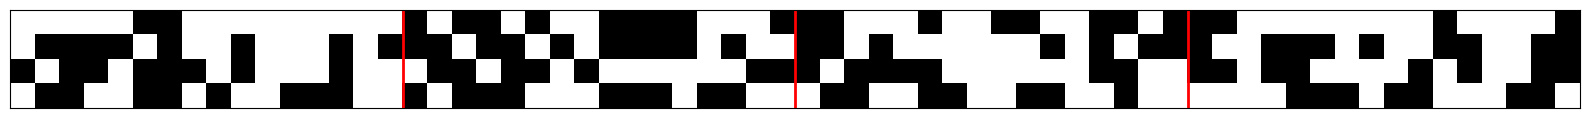

Figure 3. Rectangular 4 × 64 binary ribbon produced from the hash: 0xb519d20b79f771fd49241adb444c75ba8439b27fe65f82dc8af9157d73c9f718



In [480]:
base_hash.draw_binary_grid_from_hex(my_hash)
print(f'Figure 3. Rectangular 4 × 64 binary ribbon produced from the hash: {my_hash}\n')

### ▸ Circular Mandala

Below is the function `base_hash.draw_mandala(my_hash)`, which generates a circular mandala based on the principles described above. The linear ribbon displays the hash “as-is,” while the mandala represents the same sequence of bits folded into a circle of 64 sectors and 4 layers. This transformation reveals the symmetry and rhythm hidden in the 256-bit number while maintaining strict determinism: one hash → one form.

* The 64 sectors are arranged **clockwise**, starting at the 12 o’clock position. A red radial line is added to highlight the starting point.
* In each sector, the concentric cells from center to outer edge represent bits `b0 → b1 → b2 → b3`.
* White = 1 (*yáng*), black = 0 (*yīn*).
* The original hash is displayed in the center, split into 4 lines × 16 characters — making it easy to match text to visual.


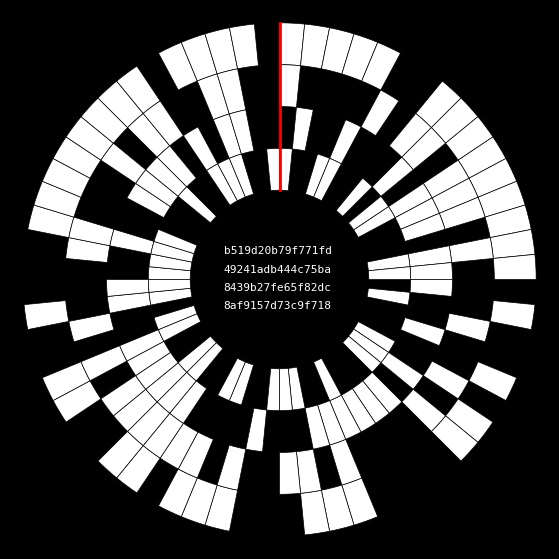

Figure 4. Circular mandala generated from the hash: 0xb519d20b79f771fd49241adb444c75ba8439b27fe65f82dc8af9157d73c9f718



In [481]:
base_hash.draw_mandala(my_hash, show_radial_line=True)
print(f'Figure 4. Circular mandala generated from the hash: {my_hash}\n')

#### ▸ Addresses as Hashes (160 bit)

In addition to 256-bit hashes, **HashJing** can also transform **Ethereum addresses** — wallet or smart contract numbers — into mandalas. Visually, these are just 40 hex characters, but in essence, they represent a truncated fragment of a Keccak-256 hash, totaling **160 bits**.

Since `base_hash.draw_mandala()` accepts any length divisible by 4, for an address we simply specify `sectors = 40`:

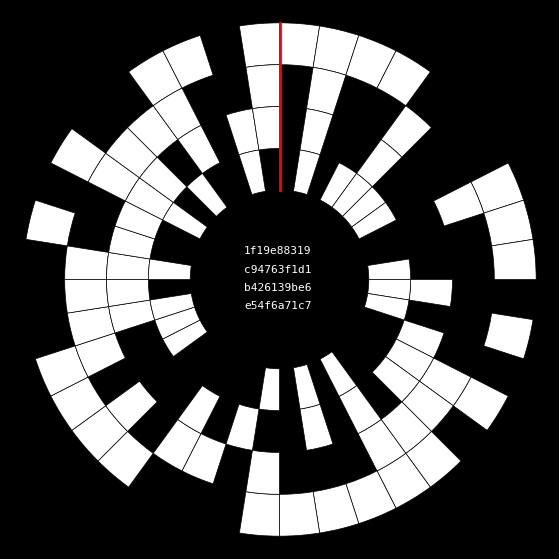

Figure 5. Circular mandala generated from the hash: 0x1f19e88319c94763f1d1b426139be6e54f6a71c7



In [470]:
my_hash_160 = base_hash.generate_random_hash(bits=160)
base_hash.draw_mandala(my_hash_160, sectors=40, show_radial_line=True)
print(f'Figure 5. Circular mandala generated from the hash: {my_hash_160}\n')

The algorithm remains the same: each hex character produces four concentric cells, so the address appears as **40 radial sectors × 4 rings**. This allows any on-chain object — whether a wallet, contract, or NFT — to be “signed“ with a mandala, while preserving HashJing’s core principle: **one hash → one unique form**.

## 4. Features of Order

This section explores properties inherent in the circular mandalas which reveal structural order. These patterns are not imposed externally; they emerge spontaneously from the discrete entropy of the hash.

### 4.1 Balanced Mandala

A 256-bit hash is called *balanced* when it contains exactly 128 ones and 128 zeros.    
In a sample of **10,000 randomly generated 256-bit hashes** using `secrets.token_hex(32)`, such mandalas appeared in approximately **5%** of cases — making them relatively rare.

Below are examples of balanced mandalas derived from both 256-bit and 160-bit hashes.

#### Balanced 256-bit Hash

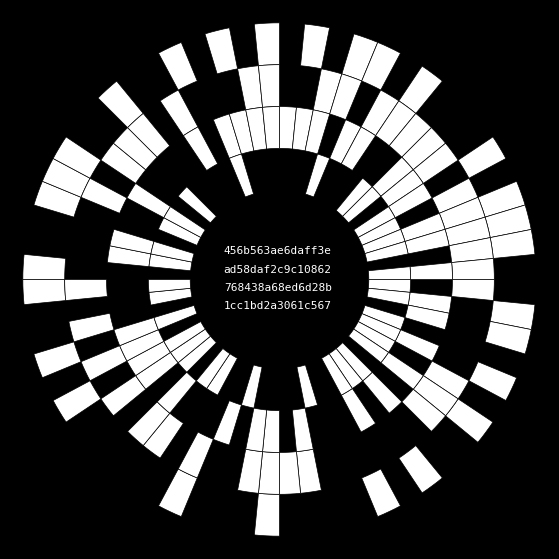

Figure 6. Balanced mandala from a 256-bit hash: 0x456b563ae6daff3ead58daf2c9c10862768438a68ed6d28b1cc1bd2a3061c567



In [463]:
balanced_hash_256 = base_hash.generate_balanced_hash()
base_hash.draw_mandala(balanced_hash_256)
print(f'Figure 6. Balanced mandala from a 256-bit hash: {balanced_hash_256}\n')

In [468]:
print(
    "Zero/one ratio for the sample 256-bit hex string "
    f'"{balanced_hash_256}" = {base_hash.bit_ratio(balanced_hash_256)}'
)
print("(For a balanced hash, this ratio should equal 1.00)")
print(f"Balance check → is_balanced: {base_hash.is_balanced(balanced_hash_256)}\n")

Zero/one ratio for the sample 256-bit hex string "0x456b563ae6daff3ead58daf2c9c10862768438a68ed6d28b1cc1bd2a3061c567" = 1.00
(For a balanced hash, this ratio should equal 1.00)
Balance check → is_balanced: True



#### Balanced 160-bit Hash

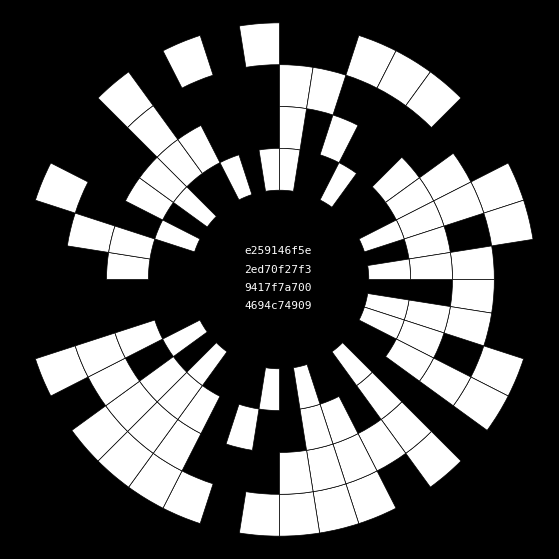

Figure 7. Balanced mandala from 160-bit hash: 0xe259146f5e2ed70f27f39417f7a7004694c74909



In [467]:
balanced_hash_160 = base_hash.generate_balanced_hash(bits=160)
base_hash.draw_mandala(balanced_hash_160, sectors=40)
print(f'Figure 7. Balanced mandala from 160-bit hash: {balanced_hash_160}\n')

In [466]:
print(
    "Zero/one ratio for the sample 160-bit hex string "
    f'"{balanced_hash_160}" = {base_hash.bit_ratio(balanced_hash_160)}'
)
print("(For a balanced hash, this ratio should equal 1.00)")
print(f"Balance check → is_balanced: {base_hash.is_balanced(balanced_hash_160)}\n")

Zero/one ratio for the sample 160-bit hex string "0x5770d8cf43fbbd053d1d55084727104cf1e736a4" = 1.00
(For a balanced hash, this ratio should equal 1.00)
Balance check → is_balanced: True



#### Theoretical probability

For a random binary string of length $n$, the chance of being perfectly balanced is

$$
P = \frac{\binom{n}{n/2}}{2^{n}}.
$$

* **256 bits:** $P \approx 4.98\%$
* **160 bits** (Ethereum addresses): $P \approx 6.30\%$

Thus perfectly balanced mandalas are rare, yet statistically inevitable—an equilibrium that emerges naturally from randomness.

### 4.2 Passages and Sealed Structures in the Mandala

Most mandalas exhibit one or more **passages** — continuous paths from the central region to the outer ring, formed entirely by zeros (black segments). These passages can be interpreted as escape routes through the labyrinth, which a hypothetical observer could follow outward.

Each passage is **isolated by impassable walls** of ones (white segments), which break connectivity between paths and prevent crossovers.

A **sealed mandala** is a special case where none of the central cells (inner ring) provide any route to the outside. No passage connects the center to the edge — even indirectly. It is essentially an *airtight labyrinth*, entirely enclosed by “white walls“.

Such structures are exceedingly rare: out of 10,000 randomly generated 256-bit hashes using `secrets.token_hex(32)`, only about **0.07%** (7 out of 10,000) resulted in sealed mandalas.

#### 4.2.1 Single-Passage Hash
As an example, let us consider mandalas with exactly one passage:

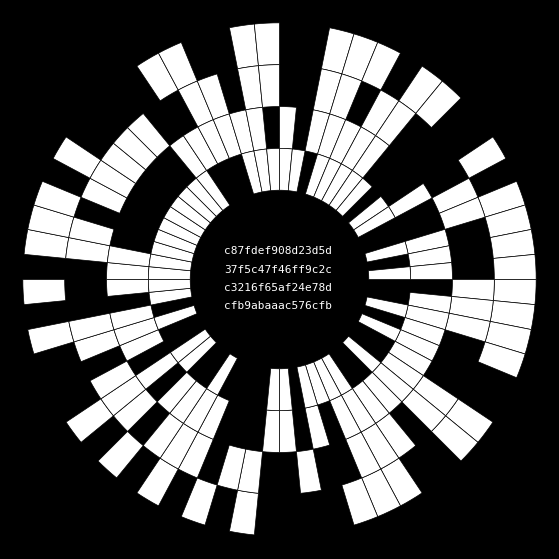

Figure 8. Single-passage mandala from 256-bit hash: 0xc87fdef908d23d5d37f5c47f46ff9c2cc3216f65af24e78dcfb9abaaac576cfb



In [485]:
single_passage_hash_256 = base_hash.generate_hash_with_passages(target_passages=1)
base_hash.draw_mandala(single_passage_hash_256)
print(f'Figure 8. Single-passage mandala from 256-bit hash: {single_passage_hash_256}\n')

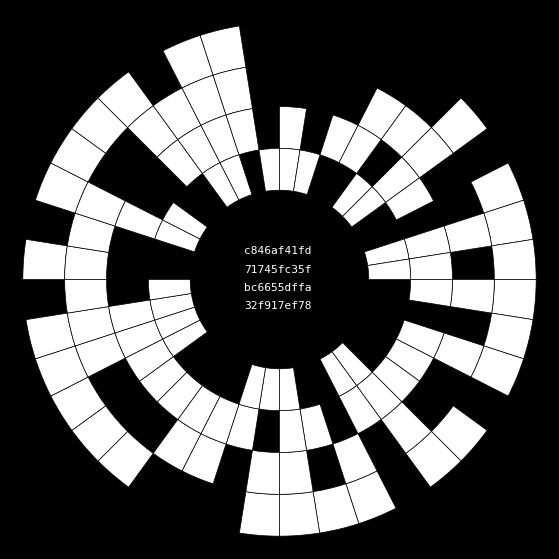

Figure 9. Single-passage mandala from 160-bit hash: 0xc846af41fd71745fc35fbc6655dffa32f917ef78



In [486]:
single_passage_hash_160 = base_hash.generate_hash_with_passages(target_passages=1, bits=160)
base_hash.draw_mandala(single_passage_hash_160, sectors=40)
print(f'Figure 9. Single-passage mandala from 160-bit hash: {single_passage_hash_160}\n')

#### 4.2.2 Determining the Number of Passages in a Mandala Generated from a Random Hash

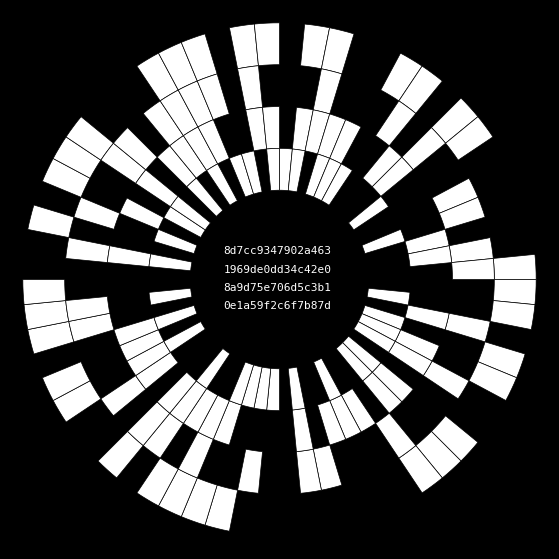

Figure 10. Mandala with 6 passages generated from a random 256-bit hash



In [494]:
random_hash_256 = base_hash.generate_random_hash()
base_hash.draw_mandala(random_hash_256)
print(f'Figure 10. Mandala with {base_hash.count_unique_passages(random_hash_256)} passages generated from a random 256-bit hash\n')

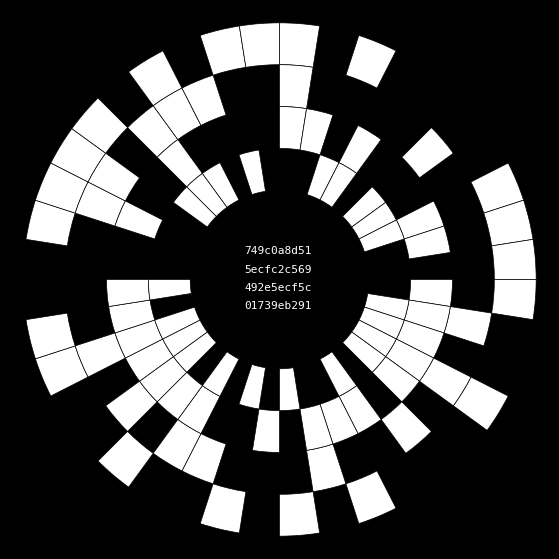

Figure 11. Mandala with 3 passages generated from a random 160-bit hash



In [496]:
random_hash_160 = base_hash.generate_random_hash(bits=160)
base_hash.draw_mandala(random_hash_160, sectors=40)
print(f'Figure 11. Mandala with {base_hash.count_unique_passages(random_hash_160)} passages generated from a random 160-bit hash\n')

#### 4.2.3 Sealed Mandala
Below are examples of *sealed* mandalas generated from 256-bit and 160-bit hashes, respectively:

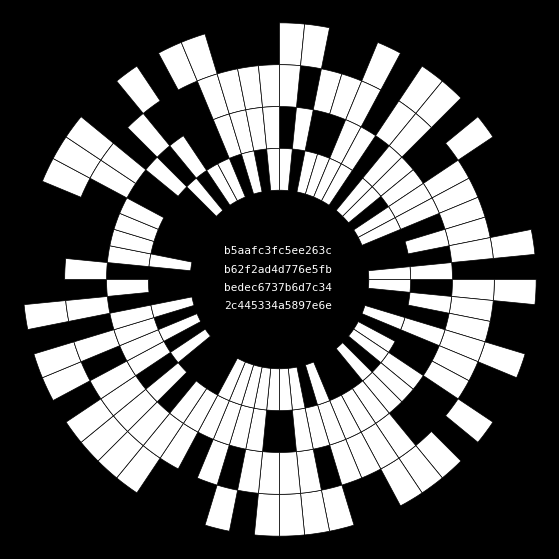

Figure 12. Sealed Mandala, generated from a random 256-bit hash



In [497]:
sealed_hash_256 = base_hash.generate_hash_with_passages(target_passages=0)
base_hash.draw_mandala(sealed_hash_256)
print(f'Figure 12. Sealed Mandala, generated from a random 256-bit hash\n')

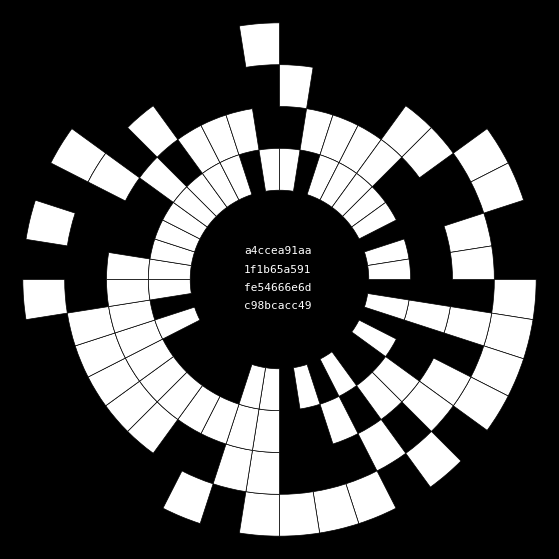

Figure 13. Sealed Mandala, generated from a random 160-bit hash



In [498]:
sealed_hash_160 = base_hash.generate_hash_with_passages(target_passages=0, bits=160)
base_hash.draw_mandala(sealed_hash_160, sectors=40)
print(f'Figure 13. Sealed Mandala, generated from a random 160-bit hash\n')

#### 4.2.4 Distribution of Passage Counts
This section explores the statistical distribution of the number of radial passages in mandalas derived from random hashes. Each passage represents a possible escape route from the center to the outer ring, defined by connected black (0-bit) segments. By generating thousands of hashes and counting the number of unique passages in each, we gain insight into how frequently sealed, single-path, or highly porous mandalas occur.

Histograms 1 and 2 show the passage-count distributions for 256-bit and 160-bit hashes, respectively.

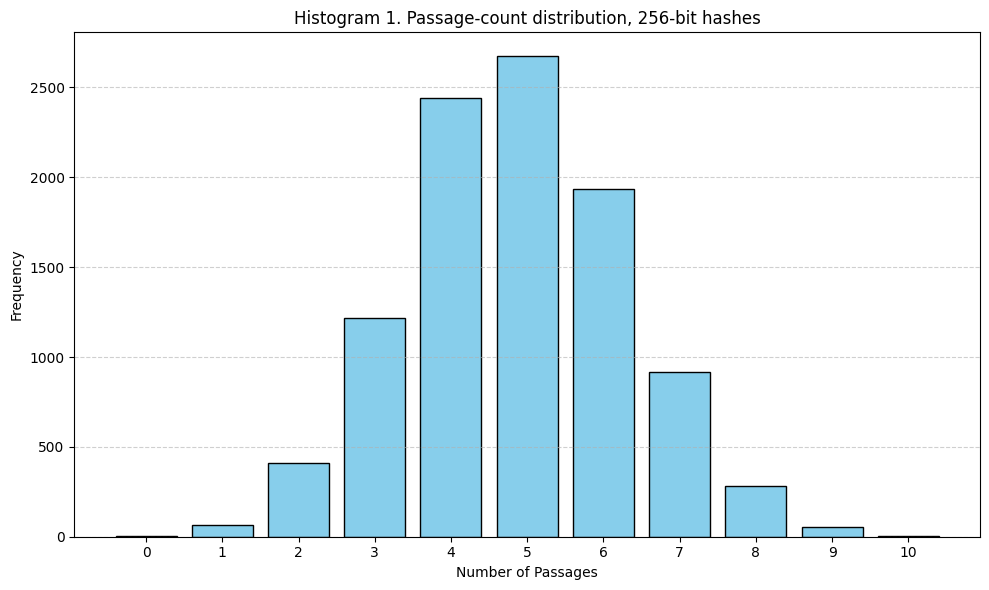

Counter({5: 2673, 4: 2440, 6: 1934, 3: 1216, 7: 916, 2: 410, 8: 283, 1: 68, 9: 54, 0: 3, 10: 3})


In [503]:
# 256-bit sample
sample_size = 10000
bit_length = 256
distribution = base_hash.passage_distribution(sample_size, bits=bit_length)
counter = Counter(distribution)

# Plotting the histogram
df = pd.DataFrame.from_dict(counter, orient='index').sort_index()
df.columns = ['Frequency']
df.index.name = 'Number of Passages'

plt.figure(figsize=(10, 6))
plt.bar(df.index, df['Frequency'], color='skyblue', edgecolor='black')
plt.title(f"Histogram 1. Passage-count distribution, 256-bit hashes")
plt.xlabel("Number of Passages")
plt.ylabel("Frequency")
plt.xticks(range(min(df.index), max(df.index)+1))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(counter)

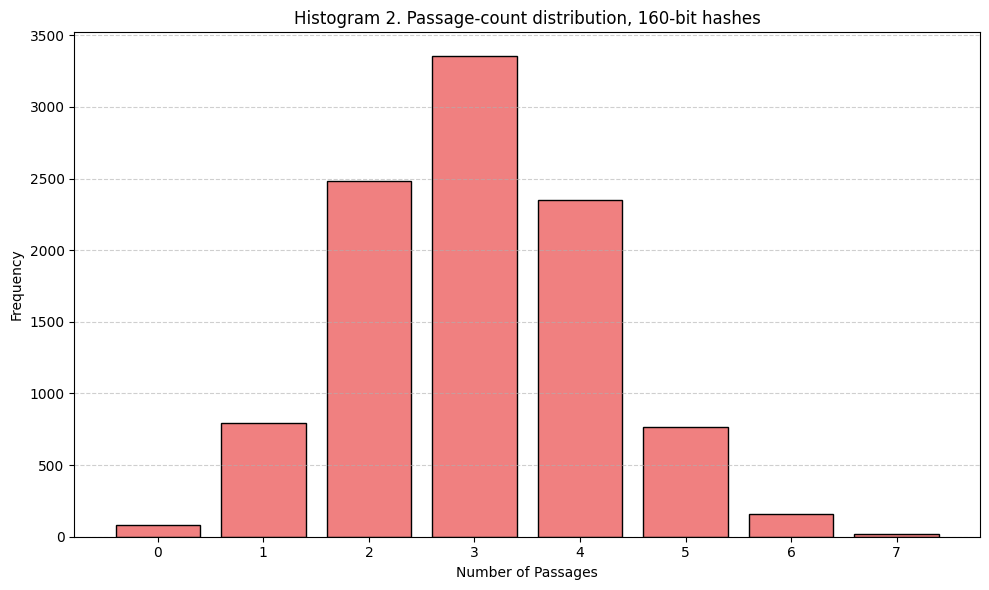

Counter({3: 3353, 2: 2480, 4: 2352, 1: 796, 5: 765, 6: 157, 0: 79, 7: 18})


In [504]:
# 160-bit sample
sample_size = 10000
bit_length = 160
distribution = base_hash.passage_distribution(sample_size, bits=bit_length)
counter = Counter(distribution)

# Plotting the histogram
df = pd.DataFrame.from_dict(counter, orient='index').sort_index()
df.columns = ['Frequency']
df.index.name = 'Number of Passages'

plt.figure(figsize=(10, 6))
plt.bar(df.index, df['Frequency'], color='lightcoral', edgecolor='black')
plt.title(f"Histogram 2. Passage-count distribution, 160-bit hashes")
plt.xlabel("Number of Passages")
plt.ylabel("Frequency")
plt.xticks(range(min(df.index), max(df.index)+1))
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(counter)

### 4.3 Simulated joint distribution

In this section, we simulate a random collection of **10,000 mandalas** derived from uniformly distributed 256-bit hashes.

For each hash, we extract two structural features:

- `num_passages`: the number of radial escape paths (i.e. distinct zero-connected routes from center to edge);
- `is_balanced`: a boolean flag indicating whether the hash contains exactly 128 zeros and 128 ones — the defining condition of a **balanced mandala**.

The following table presents the raw dataset used in this simulation.  
Each row corresponds to a single hash and its computed properties, which form the basis for the aggregated analysis in the next section.

In [509]:
df = base_hash.generate_hash_dataframe(n = 10000, bits = 256)
display(
    df.head().style
      .set_caption("Table A. Raw sample: hash, balance flag, passage count")
)

,hash,is_balanced,num_passages
0,0x9a52a9225234f47df4ceb8289292737051b5a6769b58d4f9605a6d12b70b4d11,False,4
1,0xdd318376f794de72f4c0a0a653baf6012dfeb265abd0675c1305b2df0ea3c6ab,False,6
2,0x72fbd7db14a217013f45c12fe15fc54e05562bbfc730bf43c2b56858a6be91d3,False,5
3,0x7a03b6ea133ab6a96ea766a06475b0df00997365d6391cd6b690545927a422e8,False,6
4,0x4cdcf3fc20b3a4d2530c17c0835a768306ed7dd5dd19c669a3bb74f4b380346c,True,6


#### 4.3.1 Aggregated Table: Passage Count vs. Bit Balance

The following table presents the results of the simulation. It summarizes:

- The number of hashes (`total_hashes`) for each value of `num_passages`;
- How many of those hashes (`balanced_count`) also satisfy the definition of a **balanced mandala**.

This aggregation allows us to estimate how frequently passage structure and bit balance co-occur in purely random data.

In [513]:
# Group by number of passes with column reordering
aggregation = (
    df.groupby("num_passages")
      .agg(
          total_hashes=("hash", "count"),
          balanced_count=("is_balanced", "sum")
      )
      .reset_index()[["num_passages", "total_hashes", "balanced_count"]]
)

# Print the result
display(
    aggregation.style
        .set_caption(
            "Table B. Total hashes and balanced-hash counts per passage class"
        )
)

,num_passages,total_hashes,balanced_count
0,0,8,0
1,1,74,1
2,2,357,11
3,3,1276,60
4,4,2340,124
5,5,2641,140
6,6,2020,90
7,7,961,54
8,8,262,6
9,9,51,4


#### Commentary

- The distribution of passage counts is centered around **4–6 passages**, which represent the typical structural openness of a mandala.
- **Balanced mandalas** tend to appear more frequently within this central range.
- Sealed mandalas (`num_passages = 0`) remain extremely rare.
- Very porous mandalas (`num_passages ≥ 9`) form the thin upper tail of the distribution.

These numbers quantify the structural expectations for hash-based mandalas and underscore how seldom extreme configurations occur.
